# Basics

## Approach

- Volatility-Regime Adaptation
    - Implement regime-dependent β using GRU to adjust hedge ratios based on GARCH volatility bands (e.g., high-volatility β vs. low-volatility β).
    - Validate with the double-sorting methodology from [1](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2774063), comparing returns across volatility regimes.

## Imports

In [1]:
import os
import datetime
import itertools
import random

random.seed(42)
import warnings

import backtrader as bt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from arch import arch_model
from arch.__future__ import reindexing
from matplotlib.ticker import FixedLocator, FixedFormatter
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import optuna
from optuna.trial import TrialState
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             f1_score, mean_squared_error, precision_recall_curve,
                             precision_score, recall_score, silhouette_score)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Concatenate, Dense, Dropout, Embedding, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tqdm.auto import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller, coint, kpss, OLS

from src.database.database_connectivity import DatabaseConnectivity
from src.utilities.helper import pred_color_presentation

warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["OMP_NUM_THREADS"] = "1"  # Set before importing sklearn
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logs
# logging.set_verbosity(logging.WARNING)

# create an instance of DBconnectivity
db = DatabaseConnectivity()

2025-05-03 19:58:39 : Connection to trading_database successful!


## Setup

In [2]:
# Visualization basics
# %matplotlib inline

fig_path = r'D:\PythonProjects\Trading\src\fig'  


def pred_color_presentation(c):
    custom_palette_presentation = {
        'midnight-blue': '#191970',
        'forest-green': '#228B22',
        'muted-gold': '#B8860B',
        'light-gray': '#D3D3D3',
        'sea-green': '#2E8B57',
        'teal-green': '#008080',
        'highlight': '#C19A6B',
        'red':'#a00000',
        'dark-blue': '#082A54',
        'dark-red': '#E02B35',
        'blue': '#1a80bb',
        'light-blue': '#8CC5E3',
        'black': '#000000',
        'black2': '#333333',
        'black3':'#666666',
        'black4':'#999999',
        'black5':'#CCCCCC',
        'color1':'#dfdfdf',
        'color2':'#dfb834',
        'color3':'#f1f6db',
        'color4':'#649e92',
        'color5':'#a13d61',
    }
    return custom_palette_presentation.get(c, "Invalid color name")

def pred_color(c):
    custom_palette_presentation = {
        'blue':'#1A80BB',
        'orange': '#EA801C',
        'red':'#A00000',
        'black1': '#000000',
        'black2': '#333333',
        'black3':'#666666',
        'black4':'#999999',
        'black5':'#CCCCCC',
        
    }
    return custom_palette_presentation.get(c, "Invalid color name")

# https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations

# Load and Prepare Data 

## Data Ingestion

### Sector

In [3]:
query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol;
"""

entire_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(entire_df['symbol'].unique())}")

The number of stocks selected for analysis are 1067


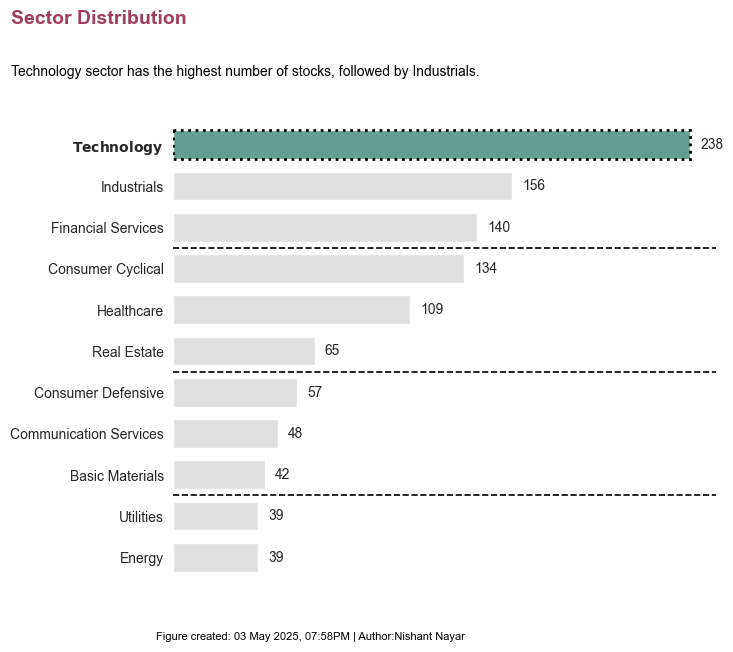

In [4]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = entire_df[['symbol', 'sector']].drop_duplicates()
sector_counts = temp_df['sector'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = sector_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if sector != max_index else pred_color_presentation('color4') for sector in sector_counts.index]

# Create a horizontal bar chart with highest at the top
ax = sector_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(sector_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for sector in sector_counts.index:
    if sector == max_index:
        yticklabels.append(f"$\\bf{{{sector}}}$")
    else:
        yticklabels.append(sector)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(sector_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(sector_counts, bar_y_positions, sector_counts.index):
    fontweight = 'bold' if sector == max_index else 'normal'
    ax.text(
        count + max(sector_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, sector in zip(bar_containers[0], sector_counts.index):
    if sector == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Sector Distribution', 
    xy=(-0.3, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{sector_counts.index[0]} sector has the highest number of stocks, followed by {sector_counts.index[1]}.', 
    xy=(-0.3, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    0.1,  
    0.01,  
    f"Figure created: {formatted_date_time} | Author:Nishant Nayar",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'industry_distribution_{sector}.jpg'
# plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()

### Technology

In [5]:
sector = 'Technology'

query = f"""
SELECT a.symbol, a.timestamp, a.close, y.longname, y.sector, y.industry
FROM yahoo_finance_info_new y, yahoo_data_hour a
WHERE y.symbol = a.symbol
AND y.sector = '{sector}';
"""

original_df = db.fetch_data(query)
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

# format sector after running query to use in code
sector = sector.lower().replace(' ', '_')

The number of stocks selected for analysis are 238


## Gaps

In [6]:
symbol_counts = pd.DataFrame(original_df['symbol'].value_counts())
high = symbol_counts['count'].head(1).values
low = symbol_counts['count'].tail(1).values
if high[0] == low[0]:
    print('The values match, no need to perform any cleaning activity.')
else:
    print('The values do not match')

The values do not match


In [7]:
# Calculate 70% of the highest count
high_percent = high[0] * 0.80

# Filter symbols
filtered_symbols = symbol_counts[symbol_counts['count']> 1800]

# Get the symbols from filtered_symbols
filtered_symbol_list = filtered_symbols.index
# Filter result_df based on the selected symbols
original_df = original_df[original_df['symbol'].isin(filtered_symbol_list)]

In [8]:
print(f"The number of stocks selected for analysis are {len(original_df['symbol'].unique())}")

The number of stocks selected for analysis are 234


In [9]:
# 1. Get the highest count
highest_count = original_df['timestamp'].value_counts().max()

# 2. Get the timestamps that have this highest count (handles ties)
most_common_timestamps = original_df['timestamp'].value_counts()[original_df['timestamp'].value_counts() == highest_count].index.tolist()

# 3. Filter the DataFrame
original_df = original_df[original_df['timestamp'].isin(most_common_timestamps)]

print(f"The number of unique stocks remaining are {len(original_df['symbol'].unique())}")

The number of unique stocks remaining are 234


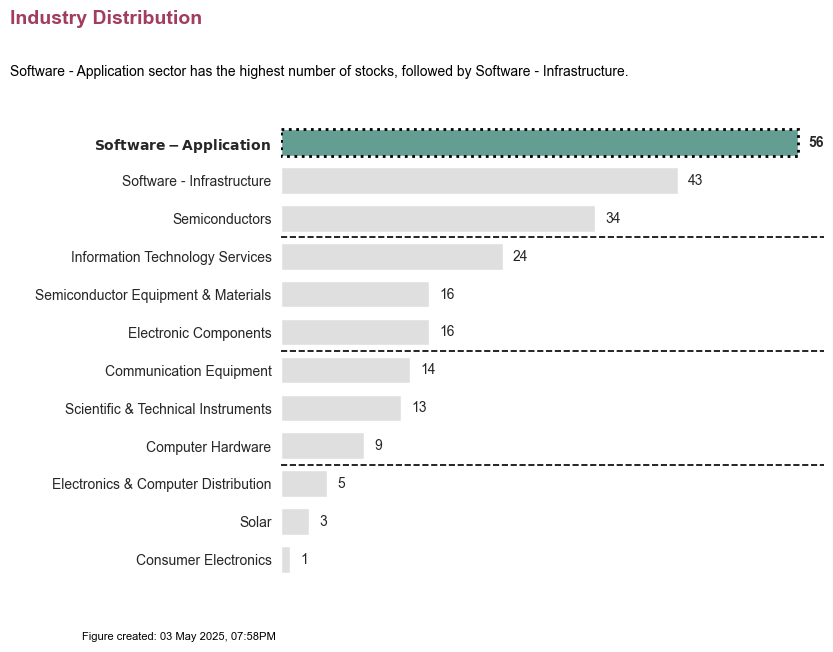

In [10]:
# Get current date and time
now = datetime.datetime.now()
formatted_date_time = now.strftime("%d %b %Y, %I:%M%p") 

# Prepare unique industry counts
temp_df = original_df[['symbol', 'industry']].drop_duplicates()
industry_counts = temp_df['industry'].value_counts().sort_values(ascending=False)

# Identify the industry with the highest count
max_index = industry_counts.idxmax()

# Define colors based on the highest count
colors = [pred_color_presentation('color1') if industry != max_index else pred_color_presentation('color4') for industry in industry_counts.index]

# Create a horizontal bar chart with highest at the top
ax = industry_counts.plot(kind='barh', figsize=(7, 6), width=0.7, color=colors)

# Reverse the order so the highest value appears at the top
ax.invert_yaxis()

# Keep y-labels but remove y-ticks
ax.set_yticks(range(len(industry_counts)))

# Make y-labels and bold the one for max industry
yticklabels = []
for industry in industry_counts.index:
    if industry == max_index:
        yticklabels.append(f"$\\bf{{{industry}}}$")
    else:
        yticklabels.append(industry)
ax.set_yticklabels(yticklabels, fontsize=10)

ax.tick_params(left=False)

# Add margin space between labels and bars
ax.margins(y=0.1)

# Add horizontal lines to group pairs of three
for i in range(3, len(industry_counts), 3):
    ax.axhline(y=i - 0.5, color='black', linestyle='dashed', linewidth=1.2)

# Customize the chart
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('')
ax.set_xticklabels([])  
ax.xaxis.set_visible(False)  
ax.grid(axis='x', linestyle='none')
ax.grid(axis='y', linestyle='none')

# Remove unnecessary spines
for spine in ['right', 'top', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Get bar positions for count labels
bar_containers = ax.containers  
bar_y_positions = [rect.get_y() + rect.get_height() / 2 for rect in bar_containers[0]]

# Add count labels with bold for the highest count
for count, y_pos, industry in zip(industry_counts, bar_y_positions, industry_counts.index):
    fontweight = 'bold' if industry == max_index else 'normal'
    ax.text(
        count + max(industry_counts) * 0.02,
        y_pos,
        str(count),
        va='center',
        ha='left',
        fontsize=10,
        fontweight=fontweight
    )

# Add a dotted border around the bar with the highest count
for rect, industry in zip(bar_containers[0], industry_counts.index):
    if industry == max_index:
        x = rect.get_x()
        y = rect.get_y()
        width = rect.get_width()
        height = rect.get_height()

        dotted_rect = patches.Rectangle(
            (x, y),
            width,
            height,
            linewidth=2,
            edgecolor='black',
            facecolor='none',
            linestyle='dotted'
        )
        ax.add_patch(dotted_rect)
        break

# Add annotation for the highest industry
plt.annotate(
    'Industry Distribution', 
    xy=(-0.5, 1.2), 
    xycoords='axes fraction', 
    fontsize=14, 
    fontweight='bold',
    ha='left', 
    va='bottom',
    color=pred_color_presentation('color5')
)

plt.annotate(
    f'{industry_counts.index[0]} sector has the highest number of stocks, followed by {industry_counts.index[1]}.', 
    xy=(-0.5, 1.09), 
    xycoords='axes fraction', 
    fontsize=10, 
    ha='left', 
    va='bottom',
    color='black'
)

# Add footnote with date and time
plt.figtext(
    -0.16,  
    0.01,  
    f"Figure created: {formatted_date_time}",
    horizontalalignment='left',
    verticalalignment='bottom',
    fontsize=8,
    color='black'
)

# Save and show the plot
fig_name = f'industry_distribution_{sector}.jpg'
# plt.savefig(os.path.join(fig_path, fig_name), bbox_inches='tight')
plt.show()